In [1]:
!export CUDA_VISIBLE_DEVICES="0"

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as Fn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [3]:
class CustomDataSet(Dataset):
    def __init__(self, csv_file):
        self.classes_k = {'Classe A':0,'Classe B':1, 'Classe C':2,'Classe D':3,'Classe E':4}
        self.df = pd.read_csv(csv_file)
        self.df = self.df.drop(['s0_gRMS', 's1_gRMS', 's2_gRMS'], axis=1)
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        label = self.classes_k[self.df.loc[index]['Classe']]
        # target = torch.zeros(5)
        # target[int(label)]=1.0
        data = torch.tensor(self.df.loc[index][2:])
        return data, label
dataset = CustomDataSet("./features_norm.csv")

In [4]:
batch_size = 16
validation_split = .3
shuffle_dataset = True
random_seed= 42
num_epochs = 200
in_features = 308
out_classes = 5

In [5]:
print(len(dataset[0][0]))

308


In [6]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)

In [7]:
class neuNet(nn.Module):
    def __init__(self, in_features, out_classes):
        super(neuNet,self).__init__()
        ## This is the number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        ## This is the linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(in_features, 128)
        ## This is also linear layer but (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,128)
        ##This is the linear layer with (n_hidden -> 10)
        self.fc4 = nn.Linear(128,out_classes)
        #The dropout layer (p=0.2)
        #Also the dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)

    def forward(self,x):
      ## adding the hidden layer, for activation we are using relu activation
        # print(sum(torch.isnan(x)))
        x = Fn.relu(self.fc1(x))
      ## adding the dropout layer
        # x = self.droput(x)
      ## adding the hidden layer, for activation we are using relu activation
        x = Fn.relu(self.fc2(x))
        x = Fn.relu(self.fc3(x))
      ## adding the dropout layer
        # x = self.droput(x)
      ## adding the output layer
        
        x = Fn.softmax(self.fc4(x), dim=1)
        print(x)
        return x
MLP_model = neuNet(in_features, out_classes)

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(308, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.layers(x)
MLP_model = SimpleMLP().double()

In [9]:
# for param in MLP_model.parameters():
#     print(param)

In [10]:
learning_rate = 0.1
MLP_criterion = nn.CrossEntropyLoss()#BCEWithLogitsLoss
Model_optimizer = torch.optim.Adam(MLP_model.parameters())

In [ ]:
train_losses = []
train_acc = []
val_loss = []
val_acc = []
best_loss = 100
for epoch in tqdm(range(100)): # monitoring the losses
    training_loss = 0
    validation_loss = 0
    train_correct = 0
    correct = 0
    MLP_model.train() ## here we are preparing the model for training
    for batch_idx, (data,label) in tqdm(enumerate(train_loader), leave=False):
        Model_optimizer.zero_grad() ## Clearing the gradients or we can say making gradients to zero of all the optimized variables
        output = MLP_model(data)
        loss = MLP_criterion(output,label) ## Calculating the loss
        loss.backward() ## backward pass, Computing the gradient of the loss w.r.t the parameters of the model
        Model_optimizer.step() ## a single step of optimization
        training_loss += loss.item() * data.size(0) ## updating the running training loss
        predicted_class = output.argmax(1)
        correct_ones = (predicted_class == label).type(torch.float)
        train_correct += correct_ones.sum().item()
        # if batch_idx%800 ==0:
        #     # print(output)
        #     print(f'Train Epoch: {epoch} b{batch_idx}\tLoss {training_loss/(data.size(0)*(batch_idx+1)):.6f}')
    print(f'train_correct = {100*train_correct/len(train_sampler)}')
    MLP_model.eval() ## here we are preparing the model for evaluation
    for data,label in tqdm(validation_loader, leave=False):
        output = MLP_model(data) ## forward passing as in this computing the predicted outputs by passing the inputs to the model
        loss = MLP_criterion(output,label) ## Calculating the loss
        validation_loss += loss.item() * data.size(0) ## updating the running validation loss
        predicted_class = output.argmax(1)
        correct_ones = (predicted_class == label).type(torch.float)
        correct += correct_ones.sum().item()
        # pred_y = torch.max(torch.exp(output),1)[1].data.cpu().numpy()
        # print(pred_y)
        # label_y = torch.max(label,1)[1].data.cpu().numpy()
        # correct += sum((pred_y == label_y))
    train_losses.append(training_loss/len(train_sampler))
    val_loss.append(validation_loss/len(valid_sampler))
    train_acc.append(100*train_correct/len(train_sampler))
    val_acc.append(correct * 100 /len(valid_sampler))
    if epoch%10==0:
        v_loss = validation_loss/len(valid_sampler)
        print(f'e{epoch}: Train Loss: {training_loss/len(train_sampler):.04f}; Val Loss: {validation_loss/len(valid_sampler):.04f} acc: {correct * 100 /len(valid_sampler):.04f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': MLP_model.state_dict(),
            'optimizer_state_dict': Model_optimizer.state_dict(),
            'loss': validation_loss/len(valid_sampler),
            }, f"./model_{epoch}.checkpoint")
        if v_loss < best_loss:
            best_loss = v_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': MLP_model.state_dict(),
                'optimizer_state_dict': Model_optimizer.state_dict(),
                'loss': validation_loss/len(valid_sampler),
                }, f"./model_best.checkpoint")

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/luizhlc/anaconda3/envs/theseus_nn/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


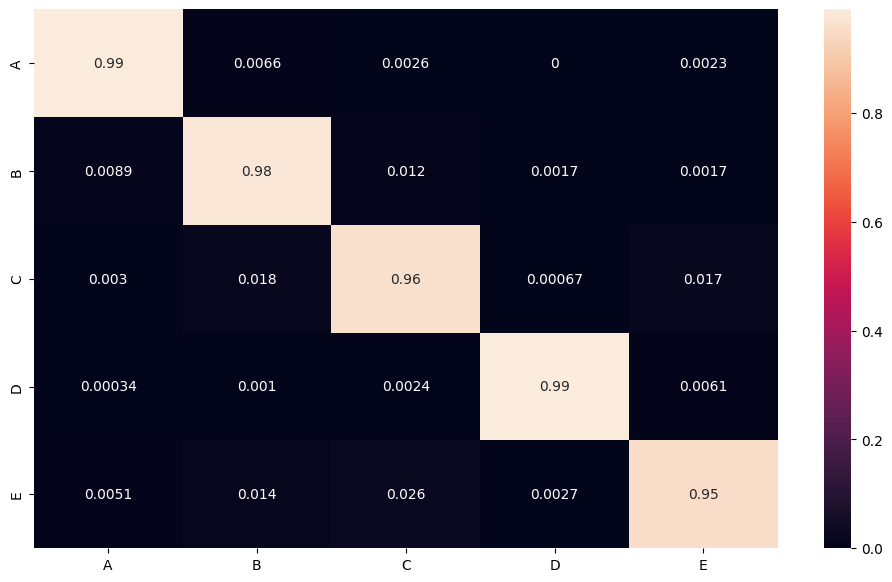

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
y_pred = []
y_true = []
testloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)
# iterate over test data
for data, labels in testloader:
    output = MLP_model(data) # Feed Network
    y_pred.extend(output.argmax(1).data.cpu().numpy()) # Save Prediction
    y_true.extend(labels.data.cpu().numpy()) # Save Truth

# constant for classes
classes = ('A', 'B', 'C', 'D', 'E')

# # Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()